# **Statistics(I)(2) - Final Project Code**
## **Task 3**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats.multicomp import MultiComparison
from scipy import stats
import seaborn as sns
import math

In [3]:
def shapiro_wilk_test(df, response_col, factor_col, alpha=0.05):
    """
    Runs Shapiro-Wilk test for normality on each group defined by a factor column.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the response variable
    - factor_col: Name of the factor variable
    - alpha: Significance level for the Shapiro-Wilk test

    Returns:
    - A dictionary of test results per group
    """
    results = {}
    print(f"Shapiro-Wilk Test for Normality (alpha = {alpha}):\n")

    for level in df[factor_col].unique():
        group_data = df[response_col][df[factor_col] == level]
        stat, p = stats.shapiro(group_data)
        results[level] = {'Shapiro Statistic': stat, 'p-value': p}
        
        print(f"For factor = {level}")
        print(f"  Shapiro statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")
        if p > alpha:
            print("→ Likely Normal")
        else:
            print("→ Not Normal")
    
    return results

In [4]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [5]:
def bartlett_test(df, response_col, factor_col, alpha=0.05):
    """
    Performs Bartlett's test for equal variances across groups.

    Parameters:
    - df: pandas DataFrame
    - response_col: Name of the numeric response variable
    - factor_col: Name of the categorical factor variable
    - alpha: Significance level for the test

    Returns:
    - (statistic, p-value)
    """
    groups = df[factor_col].unique()
    data_by_group = [df[response_col][df[factor_col] == group] for group in groups]

    stat, p = stats.bartlett(*data_by_group)
    print("Bartlett’s Test for Equal Variances:")
    print(f"  Test statistic = {stat:.6f}, p-value = {p:.6f}", end=" ")

    if p > alpha:
        print("→ Equal variances assumed")
    else:
        print("→ Variances differ significantly")

    return stat, p

In [6]:
def tukey_hsd(df, response_col, factor_col, alpha=0.05, comparison_focus=None):
    """
    Performs Tukey's HSD test and plots confidence intervals.

    Parameters:
    - df: pandas DataFrame
    - response_col: Dependent variable
    - factor_col: Categorical independent variable
    - alpha: Significance level (default 0.05)
    - comparison_focus: Optional group name to center the plot on

    Returns:
    - Tuple of (summary table, omega)
    """
    group_sizes = df.groupby(factor_col).size()
    k = len(group_sizes)
    df_within = df.shape[0] - k
    
    ng = k / np.sum(1 / group_sizes)

    model = smf.ols(f"{response_col} ~ C({factor_col})", data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    mse = aov_table.loc["Residual", "sum_sq"] / aov_table.loc["Residual", "df"]

    q_crit = qsturng(1 - alpha, k, df_within)
    omega = q_crit * np.sqrt(mse / ng)

    tukey = MultiComparison(df[response_col], df[factor_col])
    tukey_result = tukey.tukeyhsd(alpha=alpha)

    print(f"Q critical value = {q_crit:.6f}")
    print(f"Tukey Omega = {omega:.6f}")
    print(tukey_result.summary())

    _ = tukey_result.plot_simultaneous()
    plt.title("Tukey HSD Confidence Intervals")
    plt.show()

    if comparison_focus:
        _ = tukey_result.plot_simultaneous(comparison_name=comparison_focus)
        plt.title(f"Tukey HSD Focused on: {comparison_focus}")
        plt.show()

    return tukey_result.summary(), omega

---

In [26]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

filtered_df['source_category'] = (
    filtered_df['source'].apply(
        lambda x: 'Original Screenplay' if x == 'Original Screenplay' else 'Adapted'
    )
)

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.power(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.power(filtered_df["total_box_office"], 1/4)

filtered_df['z_score_bu'] = stats.zscore(filtered_df['production_budget'])
filtered_df['z_score_bo'] = stats.zscore(filtered_df['total_box_office'])
filtered_df = filtered_df[filtered_df['z_score_bu'].abs() <= 2].copy()
filtered_df = filtered_df[filtered_df['z_score_bo'].abs() <= 2].copy()

#######
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, np.inf]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

target_budgets = ['1000_2000w', '2000_3000w', '3000_4000w']
filtered_df = filtered_df[filtered_df['budget_group'].isin(target_budgets)]
#######

target_genres = ['Romantic Comedy', 'Thriller/Suspense', 'Comedy', 'Drama']
filtered_df = filtered_df[filtered_df['genre'].isin(target_genres)]
target_sources = ['Original Screenplay', 'Adapted']
filtered_df = filtered_df[filtered_df['source_category'].isin(target_sources)]
filtered_df['group_label'] = (
    filtered_df['source_category'].astype(str)
    + ' - '
    + filtered_df['genre'].astype(str)
)

In [27]:
print(filtered_df['group_label'].unique())
group_labels = ['Original Screenplay - Comedy', 'Adapted - Romantic Comedy', 
 'Original Screenplay - Thriller/Suspense', 'Adapted - Thriller/Suspense', 
 'Adapted - Drama', 'Original Screenplay - Romantic Comedy', 
 'Adapted - Comedy', 'Original Screenplay - Drama']
group_shapes = {label: filtered_df[filtered_df['group_label'] == label].shape for label in group_labels}
print()

display(group_shapes)

variances = {filtered_df["flattened_total_box_office"][filtered_df['group_label'] == label].std(ddof=1) for label in group_labels}
display(variances)

['Original Screenplay - Comedy' 'Original Screenplay - Thriller/Suspense'
 'Adapted - Thriller/Suspense' 'Adapted - Drama'
 'Original Screenplay - Romantic Comedy' 'Adapted - Comedy'
 'Original Screenplay - Drama' 'Adapted - Romantic Comedy']



{'Original Screenplay - Comedy': (319, 31),
 'Adapted - Romantic Comedy': (34, 31),
 'Original Screenplay - Thriller/Suspense': (159, 31),
 'Adapted - Thriller/Suspense': (119, 31),
 'Adapted - Drama': (404, 31),
 'Original Screenplay - Romantic Comedy': (93, 31),
 'Adapted - Comedy': (111, 31),
 'Original Screenplay - Drama': (176, 31)}

{20.42574582287083,
 24.044606091846852,
 24.644777561710775,
 24.64597062933904,
 25.524485086797984,
 25.88966838528588,
 26.19827416908014,
 26.906057617469884}

E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

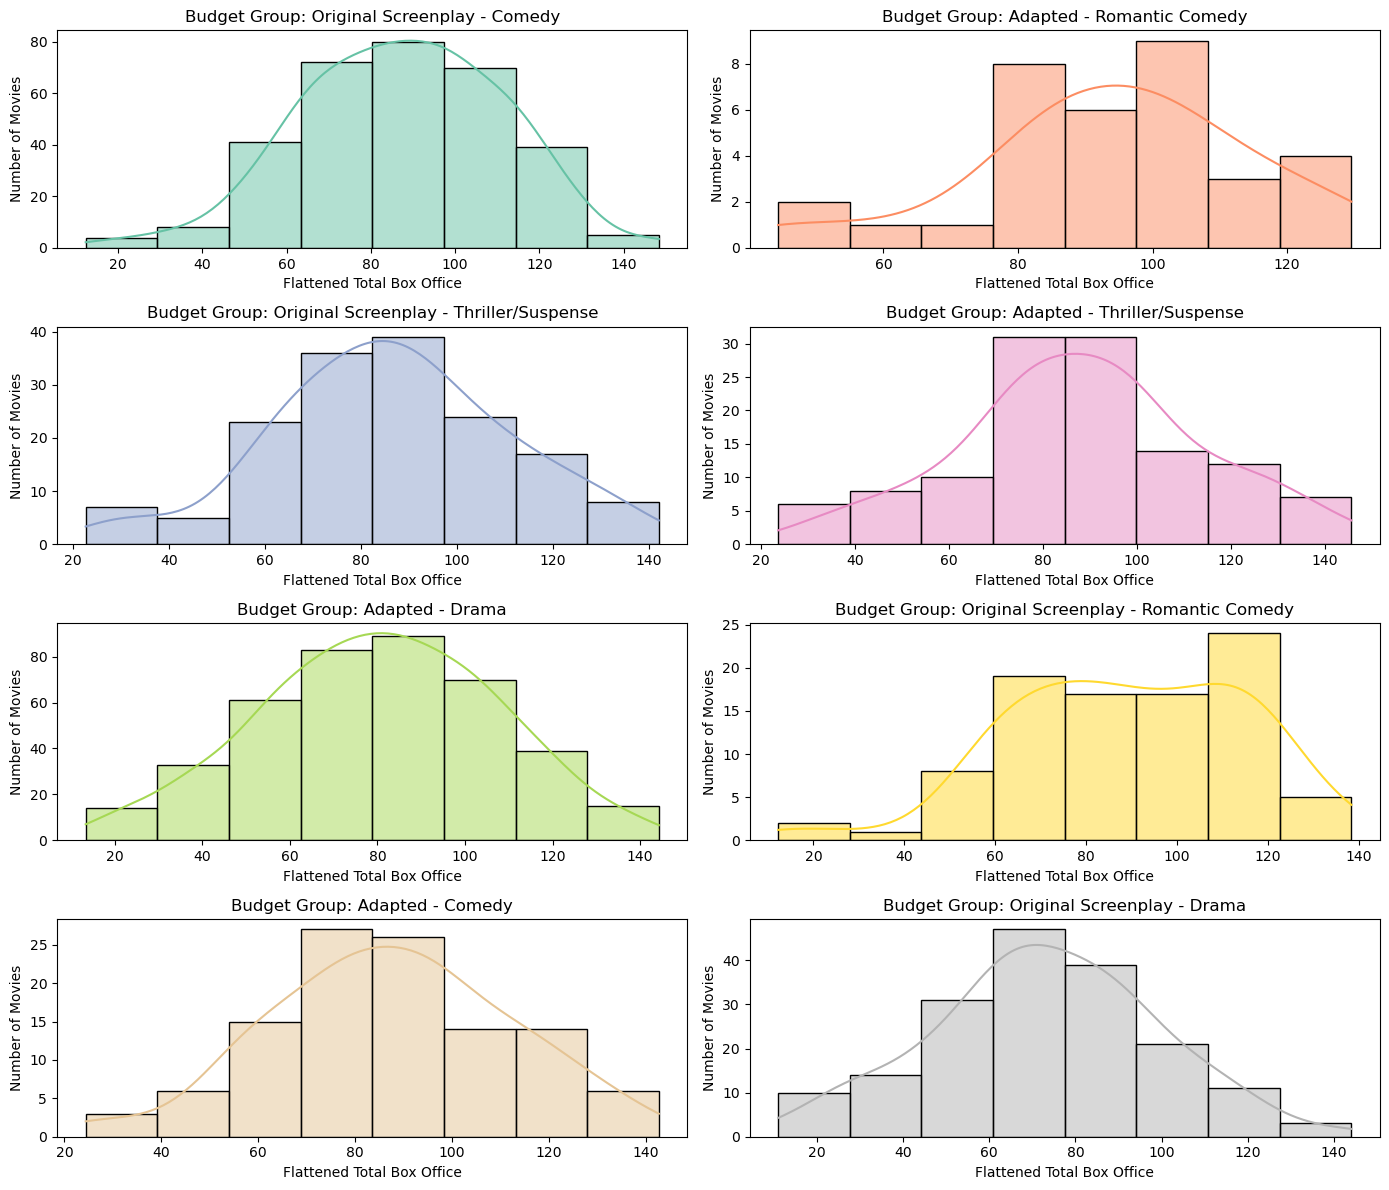

In [28]:
# 畫每個組別的票房分布
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

for i, label in enumerate(group_labels):
    sns.histplot(
        data=filtered_df[filtered_df['group_label'] == label],
        x='flattened_total_box_office',
        bins=8,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("Set2")[i]
    )
    axes[i].set_title(f"Budget Group: {label}")
    axes[i].set_xlabel("Flattened Total Box Office")
    axes[i].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

In [29]:
for label in group_labels:
    x = filtered_df['flattened_total_box_office'][filtered_df['group_label'] == label]
    try:
        c_stat, c_p = chi_square_normality_test(x, 4)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Chi-square    : {chi_msg}")


預算組別：Original Screenplay - Comedy
Chi-square    : χ² = 0.9861, p = 0.8046 → 常態

預算組別：Adapted - Romantic Comedy
Chi-square    : χ² = 0.2388, p = 0.9711 → 常態

預算組別：Original Screenplay - Thriller/Suspense
Chi-square    : χ² = 0.9830, p = 0.8054 → 常態

預算組別：Adapted - Thriller/Suspense
Chi-square    : χ² = 2.4515, p = 0.4841 → 常態

預算組別：Adapted - Drama
Chi-square    : χ² = 3.6717, p = 0.2992 → 常態

預算組別：Original Screenplay - Romantic Comedy
Chi-square    : χ² = 5.7583, p = 0.1240 → 常態

預算組別：Adapted - Comedy
Chi-square    : χ² = 2.6627, p = 0.4466 → 常態

預算組別：Original Screenplay - Drama
Chi-square    : χ² = 0.4602, p = 0.9276 → 常態


In [30]:
bartlett_result = bartlett_test(
    df=filtered_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05
)

Bartlett’s Test for Equal Variances:
  Test statistic = 8.206181, p-value = 0.314765 → Equal variances assumed


In [33]:
filtered_df['genre'] = filtered_df['genre'].astype('category')
filtered_df['source_category'] = filtered_df['source_category'].astype('category')

model = smf.ols(
    'flattened_total_box_office ~ C(genre) + C(source_category) + C(genre):C(source_category)',
    data=filtered_df
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
C(genre),37590.019908,3.0,19.356358,2.669133e-12
C(source_category),4405.170241,1.0,6.805108,9.186046e-03
C(genre):C(source_category),2749.627117,3.0,1.415875,2.364182e-01
Residual,910797.343859,1407.0,NaN,NaN


Q critical value = 4.292766
Tukey Omega = 10.586287
                                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
                group1                                 group2                 meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------------------
                     Adapted - Comedy                         Adapted - Drama  -7.1827 0.1445 -15.4591  1.0937  False
                     Adapted - Comedy               Adapted - Romantic Comedy   6.6338 0.8874  -8.5043  21.772  False
                     Adapted - Comedy             Adapted - Thriller/Suspense   0.8665    1.0  -9.3246 11.0575  False
                     Adapted - Comedy            Original Screenplay - Comedy  -0.1484    1.0  -8.6591  8.3624  False
                     Adapted - Comedy             Original Screenplay - Drama -14.3535 0.0001 -23.7143 -4.9928   True
    

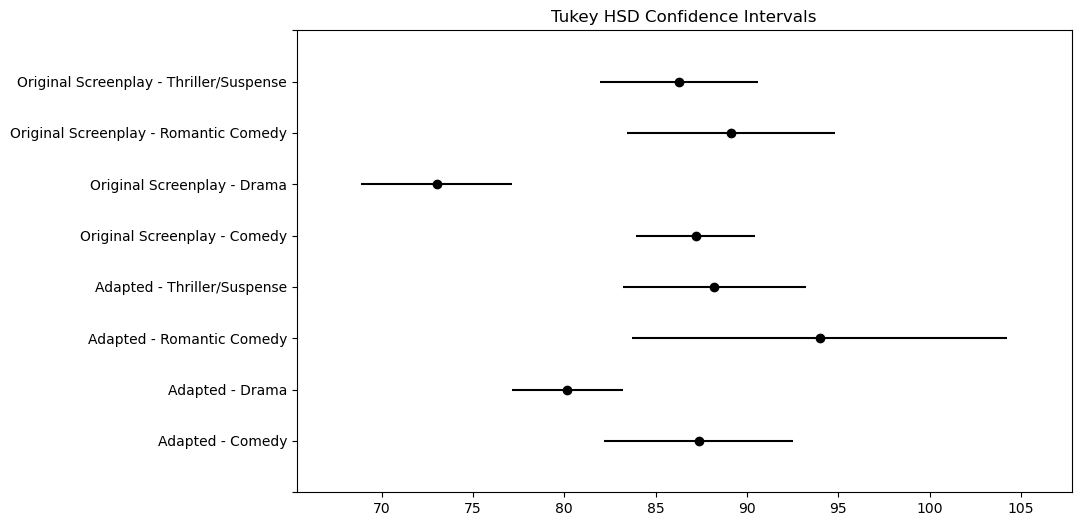

In [32]:
summary, omega = tukey_hsd(
    df=filtered_df,
    response_col='flattened_total_box_office',
    factor_col='group_label',
    alpha=0.05,
    comparison_focus=None
)